In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.applications import EfficientNetB3
from keras import layers
import utils

In [2]:
import dataset
dataset = dataset.Dataset()

In [3]:
DATAPATH = 'data/'
IMG_SIZE = 224 
SIZE = (IMG_SIZE, IMG_SIZE)
BATCH_SIZE = 32
LABELS = dataset.getLabelList()
# change labels = LABELS for regression
(train_set, test_set) = tf.keras.utils.image_dataset_from_directory(
    DATAPATH,
    image_size = SIZE,
    batch_size = BATCH_SIZE,
    labels = "inferred",
    label_mode = 'int',
    color_mode = 'rgb',
    validation_split = 0.2,
    subset = 'both',
    seed = 1234,
)

[]
0
Found 512 files belonging to 53 classes.
Using 410 files for training.
Using 102 files for validation.


In [4]:
print(train_set.class_names)
num_classes = len(train_set.class_names)
num_classes

['-1', '-10', '-11', '-12', '-13', '-14', '-15', '-16', '-17', '-18', '-19', '-2', '-20', '-21', '-22', '-23', '-24', '-25', '-26', '-29', '-3', '-30', '-31', '-34', '-35', '-38', '-4', '-5', '-6', '-7', '-70', '-8', '-9', '-950', '0', '1', '10', '11', '12', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9']


53

In [5]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    efficientnet = EfficientNetB3(include_top=False, input_tensor=inputs, weights=None)
    pooling = layers.GlobalAveragePooling2D()(efficientnet.output)
    batch_norm = layers.BatchNormalization()(pooling)
    dropout = layers.Dropout(0.2)(batch_norm)
    outputs = layers.Dense(num_classes, activation="softmax")(dropout)
    modelEfficientNet = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    modelEfficientNet.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [6]:
EPOCHS = 10

In [7]:
histEfficientNet = modelEfficientNet.fit(train_set, epochs=EPOCHS, validation_data=test_set) 

Epoch 1/10
13/13 [==============================] - 96s 5s/step - loss: 5.2539 - accuracy: 0.0610 - val_loss: 3.9447 - val_accuracy: 0.0196
Epoch 2/10
13/13 [==============================] - 68s 5s/step - loss: 4.7100 - accuracy: 0.0463 - val_loss: 3.9369 - val_accuracy: 0.0196
Epoch 3/10
13/13 [==============================] - 68s 5s/step - loss: 4.4012 - accuracy: 0.0561 - val_loss: 3.8945 - val_accuracy: 0.0490
Epoch 4/10
13/13 [==============================] - 67s 5s/step - loss: 4.4254 - accuracy: 0.0659 - val_loss: 3.8675 - val_accuracy: 0.0098
Epoch 5/10
13/13 [==============================] - 67s 5s/step - loss: 4.4580 - accuracy: 0.0951 - val_loss: 3.8393 - val_accuracy: 0.0588
Epoch 6/10
13/13 [==============================] - 68s 5s/step - loss: 4.2006 - accuracy: 0.0756 - val_loss: 3.8106 - val_accuracy: 0.0294
Epoch 7/10
13/13 [==============================] - 67s 5s/step - loss: 4.2419 - accuracy: 0.1146 - val_loss: 3.8605 - val_accuracy: 0.0196
Epoch 8/10
13/13 [==

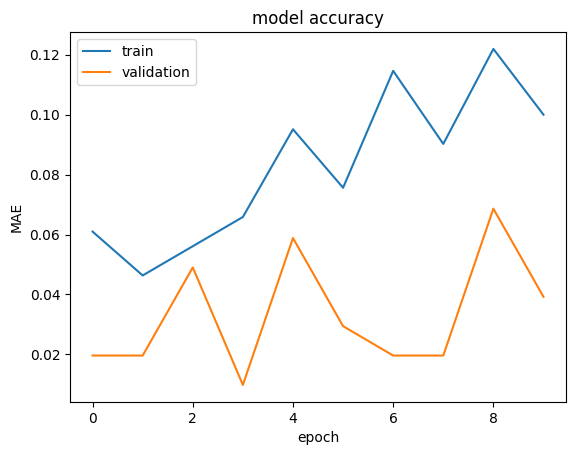

In [8]:
utils.plot_accuracy(histEfficientNet, "accuracy")